In [1]:
import pandas as pd
import numpy as np
import time
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning

## Carga de los dataset ya preparados

In [2]:
X_train_full = pd.read_csv("../data/X_train_full.csv")
y_train_full = pd.read_csv("../data/y_train_full.csv").values.ravel()
X_test = pd.read_csv("../data/X_test.csv")
y_test = pd.read_csv("../data/y_test.csv").values.ravel()
X_train = pd.read_csv("../data/X_train.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()
X_val = pd.read_csv("../data/X_val.csv")
y_val = pd.read_csv("../data/y_val.csv").values.ravel()

## Función para calcular diferentes métricas

In [3]:
def calculate_train_val(clf, X_train, y_train, X_val, y_val):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    print("--------------------------------------------\n", clf, "\n--------------------------------------------")
    print("Train RMSLE:", np.sqrt(mean_squared_error(np.log(y_train), np.log(y_train_pred))))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
    print("Train R^2:", r2_score(y_train, y_train_pred), "\n")
    y_val_pred = clf.predict(X_val) 
    print("Validation RMSLE:", np.sqrt(mean_squared_error(np.log(y_val), np.log(y_val_pred))))
    print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
    print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
    print("Validation R^2:", r2_score(y_val, y_val_pred))

## Baseline

In [4]:
clf = DummyRegressor()

In [5]:
calculate_train_val(clf, X_train, y_train, X_val, y_val)

--------------------------------------------
 DummyRegressor() 
--------------------------------------------
Train RMSLE: 0.4524639971016908
Train RMSE: 257.1718838742388
Train MAE: 176.44950355497159
Train R^2: 0.0 

Validation RMSLE: 0.4499698050847289
Validation RMSE: 253.29672169429384
Validation MAE: 175.9480864613195
Validation R^2: -7.871366087397469e-05


## Probar diferentes modelos

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
estimators = [
    ('RFR', RandomForestRegressor()),
    ('XGBR', XGBRegressor()),
    ('CAT', CatBoostRegressor(verbose=0)), 
    ]
models = {
    'LR': LinearRegression(),
    'RFR': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'GBR': GradientBoostingRegressor(),
    'LGBM': lgb.LGBMRegressor(verbose=-1),
    'XGBR': XGBRegressor(),
    'CAT': CatBoostRegressor(verbose=0),
    'HistGBR': HistGradientBoostingRegressor(),
    #'SR': StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor()),
    #'VR': VotingRegressor(estimators),
}

results = pd.DataFrame(columns=["Model", "RMSLE", "RMSE", "MAE", "R^2", "Time"])
results_list = []
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmsle = np.sqrt(mean_squared_error(np.log(y_val), np.log(y_pred)))
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    elapsed_time = time.time() - start_time
    
    results[model_name] = rmse
    #print(f'{model_name}: {rmsle}')
    results_list.append({
        "Model": model_name,
        "RMSLE": rmsle,
        "RMSE": rmse,
        "MAE": mae,
        "R^2": r2,
        "Time": f"{elapsed_time:.2f}s"
    })

results = pd.DataFrame(results_list)
results = results.sort_values(by="RMSLE", ascending=True).reset_index(drop=True)

def highlight_min(series):
    is_min = series == series.min()
    return ['background-color: yellow' if v else '' for v in is_min]

def highlight_max(series):
    is_max = series == series.max()
    return ['background-color: yellow' if v else '' for v in is_max]

results = results.style.apply(highlight_min, subset=["RMSLE", "RMSE", "MAE", "Time"]).apply(highlight_max, subset=["R^2"])
results

,Model,RMSLE,RMSE,MAE,R^2,Time
0,RFR,0.046524,35.046864,15.216727,0.980854,21.63s
1,XGBR,0.051912,36.231335,17.864325,0.979538,0.37s
2,CAT,0.053978,36.955507,18.733552,0.978712,6.06s
3,HistGBR,0.066958,43.777865,22.829337,0.970127,1.00s
4,LGBM,0.067114,43.937693,22.822676,0.969908,0.25s
5,KNN,0.123552,106.443062,44.662615,0.823392,1.50s
6,GBR,0.132336,78.232958,47.194755,0.904599,7.39s
7,LR,0.172244,104.222066,61.228809,0.830685,0.18s


## Optimización modelos

In [4]:
param_grid = {
    'n_estimators': [100, 800, 900],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'random_state': [42]
}

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800, 'random_state': 42}


## Comprobación del modelo

In [8]:
clf = RandomForestRegressor(
    n_estimators=185,
    max_depth=20,
    min_samples_split=9,
    min_samples_leaf=1,
    max_features=0.8292644974892409,
    bootstrap=True,
    random_state=42
)

In [9]:
clf = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=800,
    random_state=42
)

In [10]:
calculate_train_val(clf, X_train, y_train, X_val, y_val)

--------------------------------------------
 RandomForestRegressor(min_samples_split=5, n_estimators=800, random_state=42) 
--------------------------------------------
Train RMSLE: 0.02688097903735614
Train RMSE: 17.77981574655605
Train MAE: 8.857211222276005
Train R^2: 0.9952202240513297 

Validation RMSLE: 0.04606586834080763
Validation RMSE: 34.94726623239331
Validation MAE: 15.174995361819551
Validation R^2: 0.9809628705668857


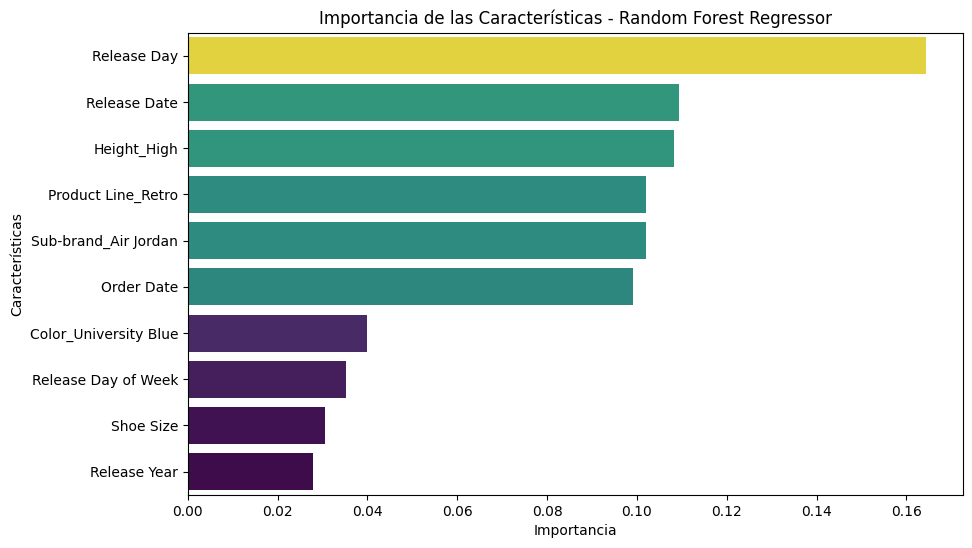

In [11]:
importances = clf.feature_importances_
features = X_train_full.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Importance', palette='viridis', legend=False)
plt.title('Importancia de las Características - Random Forest Regressor')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

## Guardado del modelo

In [12]:
def save_model(model, X, y, name_model="model1"):
    model.fit(X, y)
    with open(f'../app/models/{name_model}.pkl', 'wb') as file:
        pickle.dump(model, file) 

In [13]:
clf = XGBRegressor()

In [14]:
save_model(clf, X_train_full, y_train_full)

## Comprobación con test

In [15]:
def loaded_model(name_model="model1"):
    with open(f'../app/models/{name_model}.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

In [16]:
model_trained = loaded_model()
y_test_pred = model_trained.predict(X_test) 
print("Validation RMSLE:", np.sqrt(mean_squared_error(np.log(y_test), np.log(y_test_pred))))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Validation MAE:", mean_absolute_error(y_test, y_test_pred))
print("Validation R^2:", r2_score(y_test, y_test_pred))

Validation RMSLE: 0.0519376330073728
Validation RMSE: 36.20938441105948
Validation MAE: 17.79966271405413
Validation R^2: 0.9797221986117337
